In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored
import itertools
from itertools import combinations, product

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def is_singular(matrix):
    is_singular = np.linalg.matrix_rank(matrix) < min(matrix.shape)
    if is_singular:
        print(colored('The matrix is singular.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not singular.', 'red', attrs=['bold']))

def is_positive_definite(matrix):
    if np.all(np.linalg.eigvals(matrix) > 0):
        print(colored('The matrix is positive definite.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not positive definite.', 'red', attrs=['bold']))
        
def compute_I3(det_v1, det_v2, det_v3, det_x1v1, det_x2v2, det_x3v3, det_v1v2, det_v1v3, det_v2v3):
    I_3 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                       np.log(det_v2/det_x2v2) + \
                       np.log(det_v3/det_x3v3) - \
                       np.log(det_v1*det_v2/det_v1v2) - \
                       np.log(det_v1*det_v3/det_v1v3) - \
                       np.log(det_v2*det_v3/det_v2v3)), 4)
    print(colored(f'\nI_3 = {I_3}', 'blue', attrs=['bold']))
    return I_3

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def covariance_matrix_XV(B):
    cov_XV = np.block([[np.identity(m), B @ eigenvectors @ Sigma_V],
                       [(B @ eigenvectors @ Sigma_V).T, Sigma_V]])
    print(colored('\nCovariance matrix of joint distribution (X,V):', 'blue', attrs=['bold']))
    print(np.round(cov_XV, 4))
    return cov_XV

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def mi_VX(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(sigma_squared * B @ B.T + Sigma_W))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('Optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('Matrix A:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nMatrix B:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nCovariance matrix of W:\n{}'.format(np.round(Sigma_W, 4)))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
    else:
        print('Vector a:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nVector b:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)[0]))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nVariance of W:\n{}'.format(np.round(Sigma_W, 4)[0][0]))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))        
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

In [6]:
def generate_Sigma_V(case):
    for case_idx in range(num_cases):
        if case_idx == 0:
            # Case 1: Independent of generative parameters
            std_devs = [std_dev_v1, std_dev_v2, std_dev_v3]
            V_1 = [np.random.normal(mean, std_dev, size=num_samples) for std_dev in std_devs]

            # Compute covariance matrix of V 
            Sigma_V_1 = np.round(np.cov(V_1), 4)
        
        elif case_idx == 1:
            # Case 2: Linear dependence of v_1 and v_2, with independence of v_3
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            v_3 = np.random.normal(mean, std_dev_v3, size=num_samples)
            
            # Calculate v_2 using scaling factor alpha and random noise
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            
            # Create generative variable V
            V_2 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_2 = np.round(np.cov(V_2), 4)  
        
        else:
            # Case 3: Linear dependence of v_2 and v_3, with v_1
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            
            # Calculate additional generative parameters using scaling factors
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z3 = np.random.normal(mean, std_dev_z3, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            v_3 = beta * v_1 + random_noise_z3

            # Create generative variable V
            V_3 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_3 = np.round(np.cov(V_3), 4)
    
    if case == 0:
        print(colored('Scenario 1:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v2, sigma_v3) = {std_dev_v1, std_dev_v2, std_dev_v3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_1)
        is_singular(Sigma_V_1)
        return Sigma_V_1
    
    elif case == 1:
        print(colored('Scenario 2:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v3) = {std_dev_v1, std_dev_v3}, alpha = {alpha}, and sigma_z2 = {std_dev_z2}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_2)
        is_singular(Sigma_V_2) 
        return Sigma_V_2
    
    else:
        print(colored('Scenario 3:', attrs=['bold','underline']))
        print(f'Given sigma_v1 = {std_dev_v1}, (alpha, beta) = {alpha, beta}, and (sigma_z2, sigma_z3) = {std_dev_z2, std_dev_z3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_3)
        is_singular(Sigma_V_3)  
        return Sigma_V_3

## I. Inputs

In [7]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: s = 3, n = 4, and m = 3
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y = Gamma * Sigma_V * Gamma_T + Sigma_Z_tilde
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

# Constants
MAX_ITERS = 10000
s, n, m = 3, 4, 3
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

num_cases = 3
num_samples = int(1e7)
alpha = 2
beta = 4
mean = 0
std_dev_v1 = 0.01
std_dev_v2 = 0.02
std_dev_v3 = 0.03
std_dev_z2 = 0.02
std_dev_z3 = 0.03

# Arrays of gamma and lambda
gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('An array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

# Independent eigenvectors
eigenvectors = np.array([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1],
                         [0, 0, 0]])
print(colored('\nIndependent eigenvectors:', 'blue', attrs=['bold']))
print(eigenvectors)

# Covariance of noise Z_tilde
sigma_squared = 0.04**2
Sigma_Z_tilde = sigma_squared * np.identity(n)
print(colored('\nCovariance of noise Z_tilde:', 'blue', attrs=['bold']))
print(np.round(Sigma_Z_tilde, 4))

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]

Independent eigenvectors:
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 0]]

Covariance of noise Z_tilde:
[[0.0016 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0016]]


## II. Partitioning

In [8]:
print(colored('All ways to divide the indices of the generative parameters into three distinct groups:\n', attrs=['bold']))        

V_indices = np.arange(m+1, m+s+1)

groups_list_V = []
group_1_list_V = []
group_2_list_V = []
group_3_list_V = []
group_1_list_XV = []
group_2_list_XV = []
group_3_list_XV = []

# Initialize an empty list to store valid partitions
valid_partitions = []

# Generate all possible ways to divide the set into 3 groups
for i in range(1, len(V_indices)):
    for j in range(i + 1, len(V_indices)):
        group_1_combinations = combinations(V_indices, i)
        for group_1 in group_1_combinations:
            remaining_indices = [index for index in V_indices if index not in group_1]
            group_2_combinations = combinations(remaining_indices, j - i)
            for group_2 in group_2_combinations:
                group_3 = tuple(index for index in remaining_indices if index not in group_2)
                valid_partitions.append((set(group_1), set(group_2), set(group_3)))

# Print the valid partitions
for idx, partition in enumerate(valid_partitions, start=1):
    group_1, group_2, group_3 = partition
    print(f'Partition {idx}: Group 1: {group_1}, Group 2: {group_2}, Group 3: {group_3}')

    # Add group information to respective lists
    group_1_list_V.append(list(group_1))
    group_2_list_V.append(list(group_2))
    group_3_list_V.append(list(group_3))
    
    group_1_list_XV.append([1] + list(group_1))
    group_2_list_XV.append([2] + list(group_2))
    group_3_list_XV.append([3] + list(group_3))
    
    groups_list_V.append([e for e in list(group_1)] + [e for e in list(group_2)] + [e for e in list(group_3)])
    group_list_v1v2 = [sublist[:2] for sublist in groups_list_V]
    group_list_v1v3 = [[sublist[0], sublist[2]] for sublist in groups_list_V]
    group_list_v2v3 = [[sublist[1], sublist[2]] for sublist in groups_list_V]

All ways to divide the indices of the generative parameters into three distinct groups:

Partition 1: Group 1: {4}, Group 2: {5}, Group 3: {6}
Partition 2: Group 1: {4}, Group 2: {6}, Group 3: {5}
Partition 3: Group 1: {5}, Group 2: {4}, Group 3: {6}
Partition 4: Group 1: {5}, Group 2: {6}, Group 3: {4}
Partition 5: Group 1: {6}, Group 2: {4}, Group 3: {5}
Partition 6: Group 1: {6}, Group 2: {5}, Group 3: {4}


In [9]:
def max_I3(cov_XV):
    print(colored('\nAll ways to extract elements from the covariance matrix of joint distribution (X,V):', 'red', attrs=['bold']))    

    max_MI = -1000
    max_idx = 0
    
    I3_arr = []
    det_x1v1_arr = []
    det_x2v2_arr = []
    det_x3v3_arr = []

    # Generate an array of indices
    for i, (group_1_idx_V, group_2_idx_V, group_3_idx_V,
            group_1_idx_XV, group_2_idx_XV, group_3_idx_XV,
            group_idx_v1v2, group_idx_v1v3, group_idx_v2v3) in enumerate(zip(group_1_list_V, group_2_list_V, group_3_list_V,
                                                                             group_1_list_XV, group_2_list_XV, group_3_list_XV,
                                                                             group_list_v1v2, group_list_v1v3, group_list_v2v3)):
        
        # Generate two-digit numbers with repetition from the array and in increasing order
        group_1_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_1_idx_V, repeat=2)]
        group_2_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_2_idx_V, repeat=2)]
        group_3_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_3_idx_V, repeat=2)]
        
        group_1_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_1_idx_XV, repeat=2)]
        group_2_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_2_idx_XV, repeat=2)]
        group_3_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_3_idx_XV, repeat=2)]
        
        group_two_digit_numbers_v1v2 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v2, repeat=2)]
        group_two_digit_numbers_v1v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v3, repeat=2)]
        group_two_digit_numbers_v2v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v2v3, repeat=2)]

        print(colored(f'\nPartition {i+1}:', attrs=['bold']))
    
        # Specify the positions to extract
        tuple_list_1_V = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_V]
        tuple_list_2_V = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_V]
        tuple_list_3_V = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_V]
        
        tuple_list_1_XV = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_XV]
        tuple_list_2_XV = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_XV]
        tuple_list_3_XV = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_XV]
        
        tuple_list_v1v2 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v2]
        tuple_list_v1v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v3]
        tuple_list_v2v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v2v3]
    
        # Get the new matrix from specified positions
        dim_v1 = len(group_1_idx_V)
        dim_v2 = len(group_2_idx_V)
        dim_v3 = len(group_3_idx_V)
        
        dim_x1v1 = len(group_1_idx_XV)
        dim_x2v2 = len(group_2_idx_XV)
        dim_x3v3 = len(group_3_idx_XV)
        
        dim_v1v2 = len(group_idx_v1v2)
        dim_v1v3 = len(group_idx_v1v3)
        dim_v2v3 = len(group_idx_v2v3)
    
        cov_v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_V]).reshape(dim_v1, dim_v1)
        if len(cov_v1) == 1:
            cov_v1 = cov_v1[0]
        cov_v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_V]).reshape(dim_v2, dim_v2)
        if len(cov_v2) == 1:
            cov_v2 = cov_v2[0]
        cov_v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_V]).reshape(dim_v3, dim_v3)
        if len(cov_v3) == 1:
            cov_v3 = cov_v3[0]
    
        cov_x1v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_XV]).reshape(dim_x1v1, dim_x1v1)
        cov_x2v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_XV]).reshape(dim_x2v2, dim_x2v2)
        cov_x3v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_XV]).reshape(dim_x3v3, dim_x3v3)
        
        cov_v1v2 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v2]).reshape(dim_v1v2, dim_v1v2)
        cov_v1v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v3]).reshape(dim_v1v3, dim_v1v3)
        cov_v2v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v2v3]).reshape(dim_v2v3, dim_v2v3)
    
        print('\nCovariance matrix of generative parameters v_s1:')
        print(np.round(cov_v1, 4))
        print('Covariance matrix of generative parameters v_s2:')
        print(np.round(cov_v2, 4))
        print('Covariance matrix of generative parameters v_s3:')
        print(np.round(cov_v3, 4))
        print('Covariance matrix of joint distribution (x_1,v_s1):')
        print(np.round(cov_x1v1, 4))
        print('Covariance matrix of joint distribution (x_2,v_s2):')
        print(np.round(cov_x2v2, 4))
        print('Covariance matrix of joint distribution (x_3,v_s3):')
        print(np.round(cov_x3v3, 4))
        print('Covariance matrix of joint distribution (v_s1,v_s2):')
        print(np.round(cov_v1v2, 4))
        print('Covariance matrix of joint distribution (v_s1,v_s3):')
        print(np.round(cov_v1v3, 4))
        print('Covariance matrix of joint distribution (v_s2,v_s3):')
        print(np.round(cov_v2v3, 4))
    
        # Compute the determinant of each covariance matrix
        det_x1v1 = det(cov_x1v1)
        det_x2v2 = det(cov_x2v2)
        det_x3v3 = det(cov_x3v3)
        
        det_v1v2 = det(cov_v1v2)
        det_v1v3 = det(cov_v1v3)
        det_v2v3 = det(cov_v2v3)
        
        if len(cov_v1) == 1:
            det_v1 = cov_v1[0]
            det_x1v1_arr.append(det_x1v1) 
        else:    
            det_v1 = det(cov_v1)
            
        if len(cov_v2) == 1:
            det_v2 = cov_v2[0]
            det_x2v2_arr.append(det_x2v2) 
        else:    
            det_v2 = det(cov_v2)
            
        if len(cov_v3) == 1:
            det_v3 = cov_v3[0]
            det_x3v3_arr.append(det_x3v3) 
        else:    
            det_v3 = det(cov_v3)
    
        print(f'\nDeterminant of v_s1: {det_v1}')
        print(f'Determinant of v_s2: {det_v2}')
        print(f'Determinant of v_s3: {det_v3}') 
        print(f'Determinant of (x_1,v_s1): {det_x1v1}')
        print(f'Determinant of (x_2,v_s2): {det_x2v2}')
        print(f'Determinant of (x_3,v_s3): {det_x3v3}')
        print(f'Determinant of (v_s1,v_s2): {det_v1v2}')
        print(f'Determinant of (v_s1,v_s3): {det_v1v3}')
        print(f'Determinant of (v_s2,v_s3): {det_v2v3}')
    
        # Compute I_3
        I_3 = compute_I3(det_v1, det_v2, det_v3, 
                         det_x1v1, det_x2v2, det_x3v3, 
                         det_v1v2, det_v1v3, det_v2v3)
        I3_arr.append(I_3)
    
        if I_3 > max_MI:
            max_MI = I_3
            max_idx = i+1
    
    print(colored(f'\nThe maximum value of I_3 is {max_MI} at Partition {max_idx}.', 'red', attrs=['bold']))
    
    # Compute metric S_D
    S_D = round((max(det_x1v1_arr) / sum(det_x1v1_arr) + \
                 max(det_x2v2_arr) / sum(det_x2v2_arr) + \
                 max(det_x3v3_arr) / sum(det_x3v3_arr)) / 3, 4)
    print(colored(f'\nThe value of S_D is {S_D}.', 'red', attrs=['bold']))
    
    return I3_arr

In [10]:
def plot_I3_vs_partition(arr_I3_values):
    """
    Plots the value of I_3 over the partition.
    """
    
    x = np.arange(1, len(arr_I3_values) + 1)
    y = arr_I3_values

    # Find the index and value of the maximum I_3
    max_index = np.argmax(y)
    max_value = y[max_index]
    partition_max = max_index + 1

    # Create a scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, c='black', marker='o', s=15)
    plt.scatter(partition_max, max_value, c='red', marker='o', s=15, 
                label=f'Max I_3 = {max_value:.4f} at P{partition_max}')

    plt.xlabel('Partition', fontsize=10)
    plt.ylabel('I_3', fontsize=10)
    
    plt.legend(loc='best', fontsize=10)
    plt.show()

## III. Numerical results

Scenario 1:
Given (sigma_v1, sigma_v2, sigma_v3) = (0.01, 0.02, 0.03):

Covariance matrix of generative variable V:
[[ 0.0001 -0.     -0.    ]
 [-0.      0.0004  0.    ]
 [-0.      0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0. -0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[-0.0001  0.      0.      0.    ]
 [ 0.0002  0.      0.0001  0.    ]
 [-0.      0.      0.0001  0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0. 

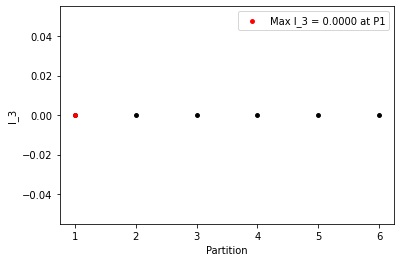


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0. -0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.0001  0.0001  0.0001  0.    ]
 [-0.      0.      0.0001  0.    ]
 [ 0.0001  0.     -0.      0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Minimum value of the cost function:
-6.6981

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

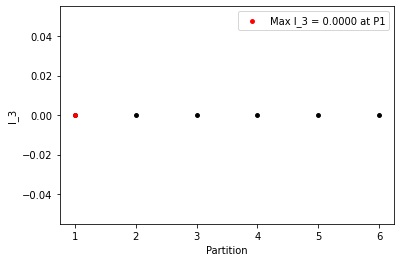


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]]

Matrix B:
[[ 0.0001  0.0001  0.0001  0.0001]
 [ 0.      0.     -0.      0.    ]
 [-0.0001 -0.0001  0.     -0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Minimum value of the cost function:
-6.698

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable and 

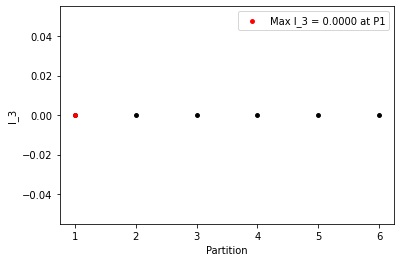


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0. -0.  0.]
 [ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.      0.0001  0.0002  0.    ]
 [-0.      0.     -0.      0.    ]
 [ 0.0001  0.      0.      0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.6979

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable an

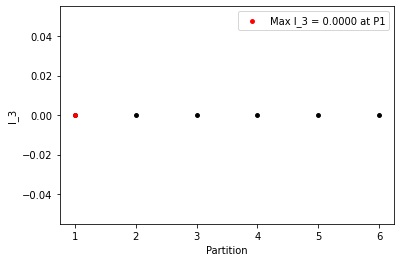


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[-0.      0.      0.      0.    ]
 [ 0.0001 -0.      0.0001  0.0001]
 [ 0.      0.0001  0.0001  0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.6979

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable an

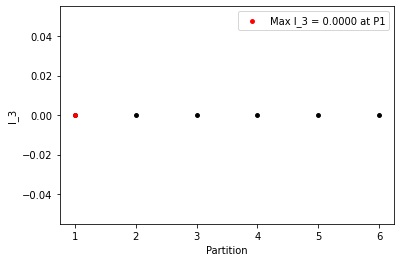


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0.  0.]
 [-0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[-0.     -0.0001  0.      0.    ]
 [ 0.0002  0.0002  0.0001  0.0001]
 [ 0.      0.0002  0.0002  0.0002]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Minimum value of the cost function:
-6.7665

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

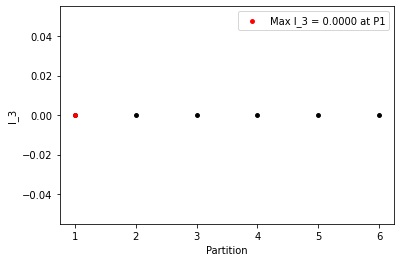


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [-0.  0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.0001  0.     -0.0001  0.0001]
 [ 0.0001  0.0002  0.0002  0.0001]
 [ 0.0002  0.0002  0.0001  0.0002]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.7665

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable a

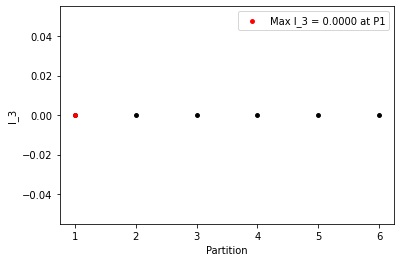


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0. -0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.0001  0.0001  0.0004  0.0001]
 [ 0.      0.      0.      0.    ]
 [-0.      0.      0.0001  0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.7664

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Reconstruction error:
0.0

Mutual information between generative variable and

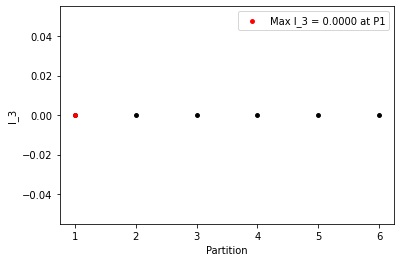


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0. -0.  0.]
 [ 0.  0. -0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]]

Matrix B:
[[ 0.      0.0003  0.0001  0.0001]
 [-0.      0.0002 -0.      0.    ]
 [ 0.0001 -0.0002  0.0001  0.0001]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Minimum value of the cost function:
-6.7663

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.      0.    ]
 [-0.      0.002  -0.      0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0.      0.      0.      0.0016]]

Reconstruction error:
0.0

Mutual information between genera

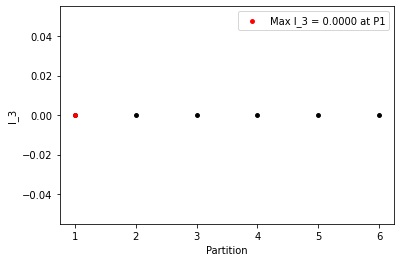


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]
 [-0.  0.  0.]]

Matrix B:
[[-0.      0.0004  0.     -0.    ]
 [ 0.     -0.0002  0.      0.    ]
 [ 0.0003  0.      0.      0.    ]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Minimum value of the cost function:
-6.7662

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.      0.    ]
 [-0.      0.002  -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0.     -0.      0.      0.0016]]

Reconstruction error:
0.0

Mutual information between gener

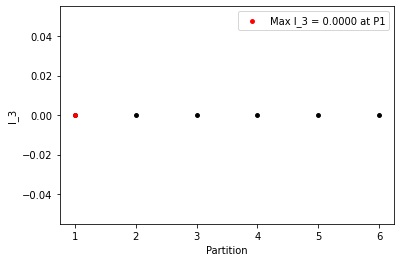


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.0001 -0.    ]
 [ 0.0002  0.0001  0.0011]
 [ 0.0014  0.0004 -0.0003]
 [ 0.     -0.0002  0.    ]]

Matrix B:
[[-0.0247  0.1082  0.5716  0.0308]
 [ 0.0814  0.0574  0.1714 -0.0959]
 [-0.0016  0.5405 -0.1327  0.0079]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.992e-01 -2.000e-04  1.000e-04]
 [-2.000e-04  9.999e-01 -0.000e+00]
 [ 1.000e-04 -0.000e+00  9.994e-01]]

Minimum value of the cost function:
-6.8349

Mutual information of the encoder:
0.0008

Mutual information of the decoder:
0.0008

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.     -0.    ]
 [ 0.      0.002  -0.      0.    ]
 [ 0.     -0. 

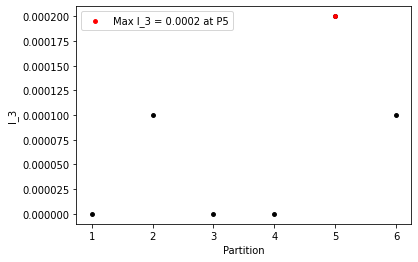


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0002  0.0002 -0.0002]
 [-0.0003  0.001   0.0007]
 [ 0.0014 -0.0006  0.0016]
 [-0.0001 -0.      0.    ]]

Matrix B:
[[ 0.1461 -0.1665  0.5783 -0.0393]
 [ 0.1158  0.4845 -0.2246 -0.0275]
 [-0.0937  0.3286  0.6241  0.0265]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.991e-01  5.000e-04 -8.000e-04]
 [ 5.000e-04  9.994e-01  1.000e-04]
 [-8.000e-04  1.000e-04  9.988e-01]]

Minimum value of the cost function:
-6.8348

Mutual information of the encoder:
0.0014

Mutual information of the decoder:
0.0014

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.     -0.    ]
 [ 0.      0.002  -0.      0.    ]
 [ 0.     -0. 

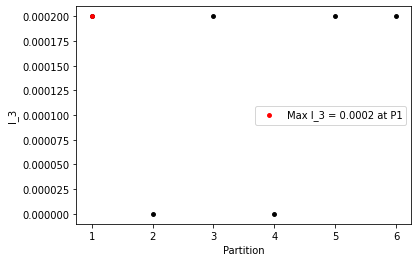


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.0002  0.    ]
 [ 0.0001 -0.0003 -0.    ]
 [ 0.0027  0.0005  0.0039]
 [-0.0006 -0.0003  0.0005]]

Matrix B:
[[-0.0265  0.0637  1.0622 -0.401 ]
 [ 0.0905 -0.1413  0.203  -0.2068]
 [ 0.0063 -0.025   1.5606  0.2998]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.969e-01 -6.000e-04 -3.900e-03]
 [-6.000e-04  9.998e-01 -7.000e-04]
 [-3.900e-03 -7.000e-04  9.938e-01]]

Minimum value of the cost function:
-6.8347

Mutual information of the encoder:
0.0048

Mutual information of the decoder:
0.0048

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.     -0.     -0.    ]
 [-0.      0.002   0.     -0.    ]
 [-0.      0.   

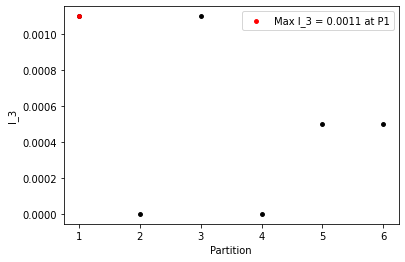


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.0002 -0.    ]
 [ 0.      0.0005 -0.    ]
 [ 0.003  -0.0001 -0.0009]
 [ 0.0005  0.0001  0.0017]]

Matrix B:
[[ 0.0014  0.0034  1.2183  0.3298]
 [ 0.1051  0.2678 -0.0295  0.0374]
 [-0.0039 -0.0103 -0.3677  1.0897]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.961e-01  1.000e-04  5.000e-04]
 [ 1.000e-04  9.998e-01 -1.000e-04]
 [ 5.000e-04 -1.000e-04  9.978e-01]]

Minimum value of the cost function:
-6.8346

Mutual information of the encoder:
0.0031

Mutual information of the decoder:
0.0031

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.      0.    ]
 [ 0.      0.002   0.     -0.    ]
 [-0.      0.  

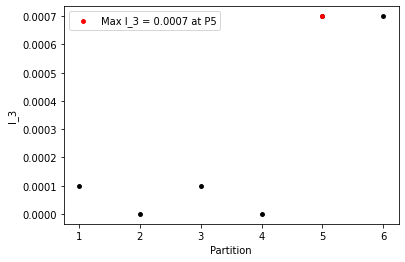


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0007  0.0003  0.0036]
 [-0.      0.0001 -0.    ]
 [ 0.0045  0.0009  0.0009]
 [ 0.0001 -0.0007  0.0001]]

Matrix B:
[[-0.4351 -0.0059  1.8149  0.0709]
 [ 0.1682  0.0355  0.3409 -0.4257]
 [ 2.1384 -0.004   0.3425  0.0479]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.914e-01 -1.400e-03  0.000e+00]
 [-1.400e-03  9.994e-01 -9.000e-04]
 [ 0.000e+00 -9.000e-04  9.919e-01]]

Minimum value of the cost function:
-6.8346

Mutual information of the encoder:
0.0087

Mutual information of the decoder:
0.0087

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.      0.    ]
 [-0.      0.002   0.     -0.    ]
 [ 0.      0.      0.002

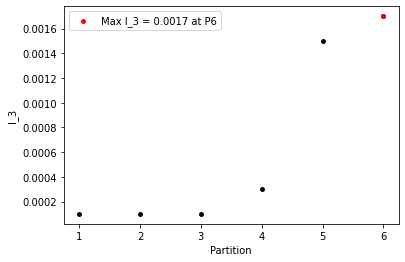


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0215  0.035   0.0023]
 [-0.0302  0.0167  0.0282]
 [ 0.     -0.      0.    ]
 [ 0.0206 -0.0148  0.0308]]

Matrix B:
[[ 12.7222 -15.1856   0.      12.9574]
 [ 20.6738   8.3959  -0.      -9.2675]
 [  1.3824  14.1915   0.      19.3478]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-9.5927

Mutual information of the encoder:
68.4638

Mutual information of the decoder:
68.4415

Value of Sigma_X:
[[ 1.005  0.     0.   ]
 [ 0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.     -0.    ]
 [ 0.      0.002  -0.      0.    ]
 [-0.     -0.      0.0025  0.    

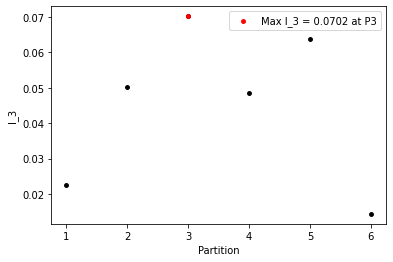


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0305 -0.0193  0.0197]
 [ 0.0277  0.0334 -0.0102]
 [-0.     -0.     -0.    ]
 [-0.01    0.0187  0.0338]]

Matrix B:
[[ 18.0421  13.9398  -0.      -6.2738]
 [-11.4163  16.7826  -0.      11.7289]
 [ 11.6327  -5.1497  -0.      21.2412]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-9.6008

Mutual information of the encoder:
69.2841

Mutual information of the decoder:
69.2617

Value of Sigma_X:
[[ 1.005 -0.     0.   ]
 [-0.     1.005  0.   ]
 [ 0.     0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.      0.    ]
 [ 0.      0.002  -0.      0.    ]
 [-0.     -0.      0.0025 -0.    

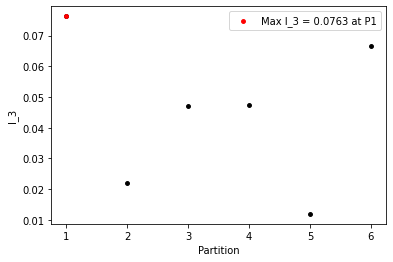


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.005 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.      0.    ]
 [-0.0045  0.0277  0.0346]
 [ 0.0212 -0.0338  0.0299]
 [ 0.0359  0.0156 -0.0078]]

Matrix B:
[[ -0.      -2.2857   8.512   22.5472]
 [ -0.      13.9411 -13.6065   9.7927]
 [  0.      17.4045  12.0168  -4.8829]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-9.5969

Mutual information of the encoder:
68.8959

Mutual information of the decoder:
68.8735

Value of Sigma_X:
[[ 1.005 -0.     0.   ]
 [-0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.     -0.    ]
 [-0.      0.002   0.      0.    ]
 [ 0.      0.      0.0025 -0.    ]


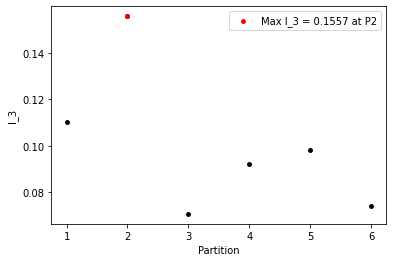


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.005 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.      0.    ]
 [-0.0001  0.0446 -0.0015]
 [ 0.0417  0.0011  0.0273]
 [-0.0218  0.0011  0.0334]]

Matrix B:
[[  0.      -0.068   16.7814 -13.7144]
 [ -0.      22.4028   0.4312   0.6856]
 [  0.      -0.777   10.9632  20.9657]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
33086.08

Mutual information of the encoder:
69.2016

Mutual information of the decoder:
69.1793

Value of Sigma_X:
[[ 1.005  0.     0.   ]
 [ 0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.      0.    ]
 [-0.      0.002  -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    

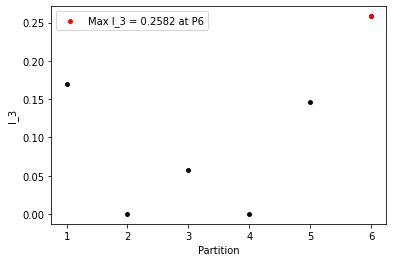


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0278  0.0246 -0.0177]
 [ 0.029  -0.0093  0.0326]
 [-0.      0.     -0.    ]
 [-0.0139  0.0309  0.0211]]

Matrix B:
[[ 16.4369  14.5518  -0.      -8.7388]
 [ 14.5573  -4.6637   0.      19.3848]
 [-10.4443  16.4009  -0.      13.2657]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
33086.0886

Mutual information of the encoder:
68.3431

Mutual information of the decoder:
68.3207

Value of Sigma_X:
[[ 1.005 -0.     0.   ]
 [-0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.     -0.      0.    ]
 [-0.      0.002  -0.     -0.    ]
 [-0.     -0.      0.0025  0.  

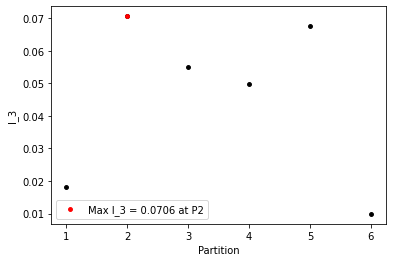


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0079 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0345  0.0074 -0.0209]
 [-0.002   0.0428  0.0119]
 [ 0.     -0.     -0.    ]
 [ 0.0214 -0.0081  0.0326]]

Matrix B:
[[ 20.523   -0.9955   0.      13.5079]
 [  4.3866  21.6311  -0.      -5.0884]
 [-12.3958   6.0065  -0.      20.5636]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.8529

Mutual information of the encoder:
143.5911

Mutual information of the decoder:
143.5465

Value of Sigma_X:
[[ 1.01  0.    0.  ]
 [ 0.    1.01 -0.  ]
 [ 0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.      0.      0.    ]
 [-0.      0.002  -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 

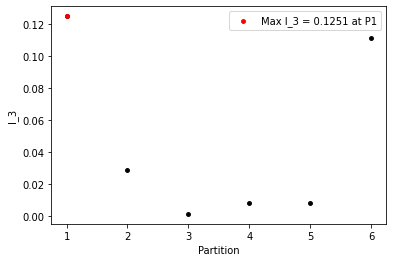


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0079 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0209  0.009   0.0341]
 [ 0.0013  0.0432 -0.0106]
 [ 0.     -0.     -0.    ]
 [ 0.0342  0.0038  0.02  ]]

Matrix B:
[[-12.4184   0.674    0.      21.6055]
 [  5.3508  21.8166  -0.       2.417 ]
 [ 20.2791  -5.3438  -0.      12.5929]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0.  0.]
 [ 0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
1.1837801625666449e+26

Mutual information of the encoder:
142.3279

Mutual information of the decoder:
142.2834

Value of Sigma_X:
[[ 1.01 -0.    0.  ]
 [-0.    1.01  0.  ]
 [ 0.    0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.     -0.      0.    ]
 [-0.      0.002  -0.     -0.    ]
 [-0.     -0.      0.002

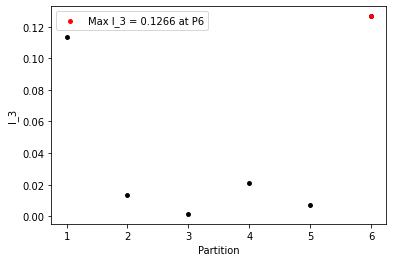


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0079 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0214 -0.0235  0.0259]
 [ 0.0347  0.0276 -0.0037]
 [-0.      0.     -0.    ]
 [-0.0137  0.0213  0.0307]]

Matrix B:
[[ 12.7359  17.5175  -0.      -8.6776]
 [-13.9397  13.9523   0.      13.4694]
 [ 15.4133  -1.8561   0.      19.3519]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-7.8918677504443e+25

Mutual information of the encoder:
142.5249

Mutual information of the decoder:
142.4803

Value of Sigma_X:
[[ 1.01 -0.   -0.  ]
 [-0.    1.01  0.  ]
 [-0.    0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.     -0.      0.    ]
 [ 0.      0.002   0.     -0.    ]
 [-0.      0.      0.0025  0

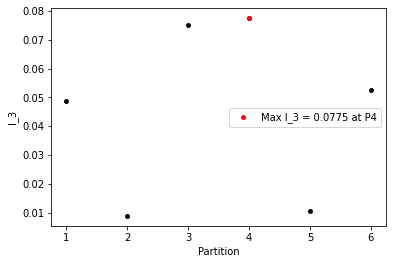


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0099 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0232  0.0317 -0.012 ]
 [ 0.      0.      0.    ]
 [ 0.0297 -0.0068  0.0393]
 [-0.0227  0.0247  0.0214]]

Matrix B:
[[ 13.7542   0.      12.0038 -14.3204]
 [ 18.8172   0.      -2.7565  15.5926]
 [ -7.1289   0.      15.8837  13.5283]]

Covariance matrix of Z:
[[0.    0.    0.    0.   ]
 [0.    0.002 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-11.8474

Mutual information of the encoder:
143.319

Mutual information of the decoder:
143.2744

Value of Sigma_X:
[[ 1.01 -0.    0.  ]
 [-0.    1.01 -0.  ]
 [ 0.   -0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017  0.      0.     -0.    ]
 [ 0.      0.002   0.     -0.    ]
 [ 0.      0.      0.0025 -0.    ]
 [-0.     -0.     -0.

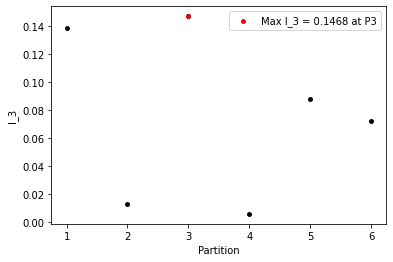


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0079 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0275  0.0297 -0.0068]
 [-0.0094  0.0178  0.0397]
 [-0.     -0.     -0.    ]
 [ 0.0284 -0.0224  0.0167]]

Matrix B:
[[ 16.3084  -4.739   -0.      17.9042]
 [ 17.6582   8.9637  -0.     -14.1238]
 [ -4.039   20.0542  -0.      10.5439]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-7.8918677504443e+25

Mutual information of the encoder:
142.7511

Mutual information of the decoder:
142.7066

Value of Sigma_X:
[[ 1.01  0.   -0.  ]
 [ 0.    1.01  0.  ]
 [-0.    0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0017 -0.     -0.      0.    ]
 [-0.      0.002  -0.     -0.    ]
 [-0.     -0.      0.0025 -

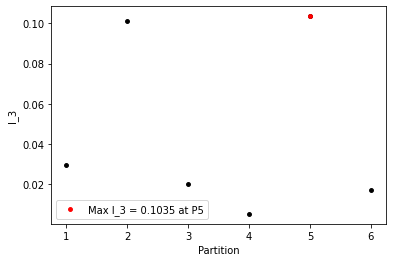

Scenario 2:
Given (sigma_v1, sigma_v3) = (0.01, 0.03), alpha = 2, and sigma_z2 = 0.02:

Covariance matrix of generative variable V:
[[ 0.0001  0.0002 -0.    ]
 [ 0.0002  0.0008  0.    ]
 [-0.      0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.0002 0.     0.    ]
 [0.0002 0.0024 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0079  0.0081 -0.0029]
 [ 0.0094  0.0096 -0.0035]
 [ 0.     -0.      0.    ]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 4.2236  3.5522  0.      0.    ]
 [ 4.3293  3.6411 -0.     -0.    ]
 [-1.5779 -1.327   0.      0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]

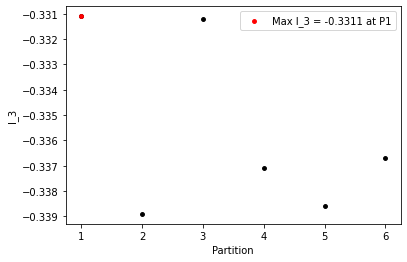


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0104  0.0047  0.0025]
 [ 0.0124  0.0055  0.003 ]
 [-0.     -0.      0.    ]
 [ 0.     -0.     -0.    ]]

Matrix B:
[[ 5.5724  4.6882 -0.      0.    ]
 [ 2.4904  2.0953 -0.     -0.    ]
 [ 1.3499  1.1357  0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.884  -0.0518 -0.0281]
 [-0.0518  0.9768 -0.0126]
 [-0.0281 -0.0126  0.9932]]

Minimum value of the cost function:
-6.6118

Mutual information of the encoder:
0.0789

Mutual information of the decoder:
0.0804

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.      0.0025 -0.    ]
 [ 

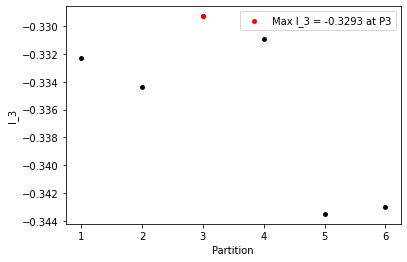


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0033  0.003   0.0108]
 [ 0.0039  0.0036  0.0128]
 [ 0.      0.     -0.    ]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 1.7614  1.4825  0.     -0.    ]
 [ 1.6068  1.3523  0.      0.    ]
 [ 5.7789  4.8637 -0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9884 -0.0106 -0.038 ]
 [-0.0106  0.9904 -0.0347]
 [-0.038  -0.0347  0.8752]]

Minimum value of the cost function:
-6.6117

Mutual information of the encoder:
0.0789

Mutual information of the decoder:
0.0804

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0.

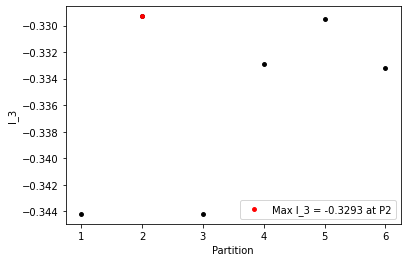


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0101  0.0037  0.0046]
 [ 0.012   0.0044  0.0055]
 [ 0.     -0.      0.    ]
 [-0.     -0.      0.    ]]

Matrix B:
[[ 5.3942  4.5415  0.     -0.    ]
 [ 1.9895  1.675  -0.     -0.    ]
 [ 2.4555  2.0673  0.      0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8912 -0.0401 -0.0495]
 [-0.0401  0.9852 -0.0183]
 [-0.0495 -0.0183  0.9775]]

Minimum value of the cost function:
-6.6117

Mutual information of the encoder:
0.079

Mutual information of the decoder:
0.0805

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.      0.      0.0025  0.    ]
 [ 0.     -0. 

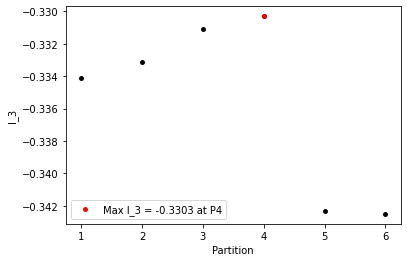


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0104  0.0039  0.0036]
 [ 0.0124  0.0047  0.0043]
 [ 0.      0.     -0.    ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 5.5679  4.6894  0.      0.    ]
 [ 2.1032  1.7713  0.      0.    ]
 [ 1.9139  1.612  -0.     -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8841 -0.0438 -0.0398]
 [-0.0438  0.9835 -0.0151]
 [-0.0398 -0.0151  0.9863]]

Minimum value of the cost function:
-6.6116

Mutual information of the encoder:
0.079

Mutual information of the decoder:
0.0805

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.      0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0.      0. 

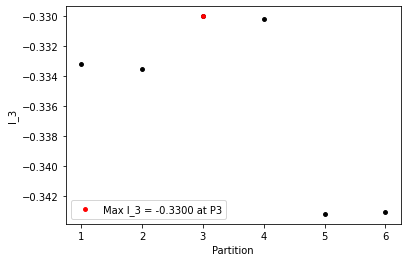


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0075 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0025 -0.0008  0.0121]
 [ 0.003  -0.001   0.0143]
 [-0.      0.      0.    ]
 [-0.      0.      0.    ]]

Matrix B:
[[ 1.3457  1.131  -0.     -0.    ]
 [-0.4445 -0.3736  0.      0.    ]
 [ 6.4624  5.4314  0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9932  0.0022 -0.0325]
 [ 0.0022  0.9993  0.0107]
 [-0.0325  0.0107  0.8442]]

Minimum value of the cost function:
-6.6802

Mutual information of the encoder:
0.0892

Mutual information of the decoder:
0.09

Value of Sigma_X:
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024  0.      0.    ]
 [-0.      0.      0.0025  0.    ]
 [-0.

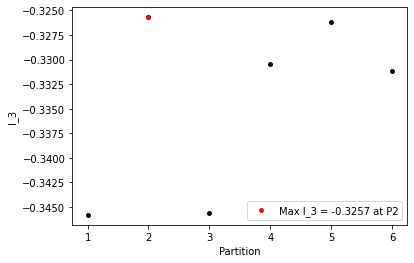


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0075 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0091 -0.0032  0.0077]
 [ 0.0108 -0.0038  0.0091]
 [-0.     -0.      0.    ]
 [-0.     -0.      0.    ]]

Matrix B:
[[ 4.879   4.1034 -0.     -0.    ]
 [-1.7167 -1.4438 -0.     -0.    ]
 [ 4.1239  3.4684  0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9111  0.0313 -0.0751]
 [ 0.0313  0.989   0.0264]
 [-0.0751  0.0264  0.9365]]

Minimum value of the cost function:
-6.6801

Mutual information of the encoder:
0.0892

Mutual information of the decoder:
0.09

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0.

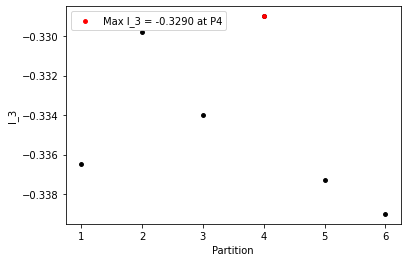


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0074 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0042  0.      0.0116]
 [ 0.005   0.0001  0.0138]
 [ 0.      0.     -0.    ]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 2.2529  1.8961  0.      0.    ]
 [ 0.0257  0.0216  0.      0.    ]
 [ 6.2184  5.2335 -0.     -0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 9.810e-01 -2.000e-04 -5.230e-02]
 [-2.000e-04  1.000e+00 -6.000e-04]
 [-5.230e-02 -6.000e-04  8.555e-01]]

Minimum value of the cost function:
-6.6801

Mutual information of the encoder:
0.0892

Mutual information of the decoder:
0.0901

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.     0.    ]
 [0.0002 0.0024 0.     0.    ]
 [0.     0.     0.0025 0.    ]

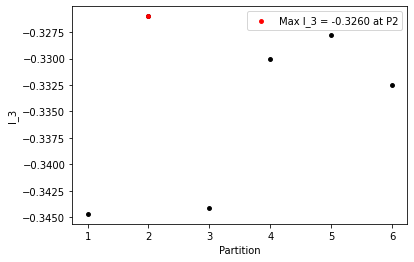


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0074 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0037  0.0088  0.0079]
 [-0.0044  0.0104  0.0094]
 [ 0.     -0.      0.    ]
 [ 0.     -0.      0.    ]]

Matrix B:
[[-1.9637 -1.6538  0.      0.    ]
 [ 4.6937  3.9531 -0.     -0.    ]
 [ 4.2242  3.5577  0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9856  0.0345  0.031 ]
 [ 0.0345  0.9176 -0.0741]
 [ 0.031  -0.0741  0.9333]]

Minimum value of the cost function:
-6.68

Mutual information of the encoder:
0.0893

Mutual information of the decoder:
0.0901

Value of Sigma_X:
[[ 1. -0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0. 

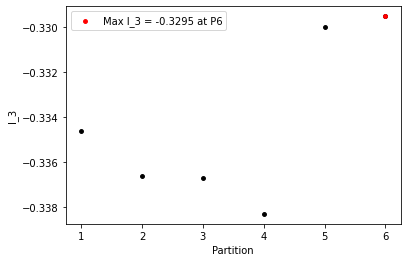


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0074 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0047  0.0049  0.0103]
 [ 0.0056  0.0058  0.0123]
 [-0.      0.     -0.    ]
 [-0.      0.      0.    ]]

Matrix B:
[[ 2.5353  2.1367 -0.     -0.    ]
 [ 2.5971  2.1889  0.      0.    ]
 [ 5.5267  4.658  -0.      0.    ]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9759 -0.0246 -0.0524]
 [-0.0246  0.9748 -0.0537]
 [-0.0524 -0.0537  0.8857]]

Minimum value of the cost function:
-6.6799

Mutual information of the encoder:
0.0893

Mutual information of the decoder:
0.0901

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [ 0.     -0

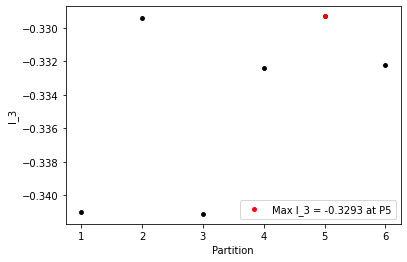


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0031 -0.007   0.0112]
 [ 0.0034 -0.0077  0.0122]
 [ 0.      0.0001  0.0001]
 [ 0.0036  0.0003 -0.0008]]

Matrix B:
[[ 1.6634e+00  1.2594e+00  3.0000e-03  2.2604e+00]
 [-3.7949e+00 -2.8803e+00  5.6400e-02  1.9050e-01]
 [ 6.0280e+00  4.5612e+00  3.4800e-02 -5.0380e-01]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9825  0.0207 -0.032 ]
 [ 0.0207  0.9512  0.0775]
 [-0.032   0.0775  0.8769]]

Minimum value of the cost function:
-6.7486

Mutual information of the encoder:
0.1041

Mutual information of the decoder:
0.1041

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024 -0.    

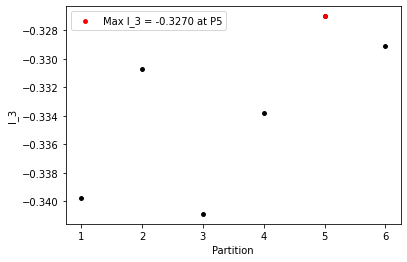


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0037  0.0112  0.0061]
 [ 0.0042  0.0127  0.0068]
 [ 0.0004 -0.0004  0.0006]
 [ 0.0002  0.     -0.0002]]

Matrix B:
[[ 2.007   1.5978  0.1742  0.1449]
 [ 6.0378  4.7909 -0.1772  0.0291]
 [ 3.2676  2.5786  0.2208 -0.1432]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9856 -0.0428 -0.0232]
 [-0.0428  0.8713 -0.0693]
 [-0.0232 -0.0693  0.9624]]

Minimum value of the cost function:
-6.7486

Mutual information of the encoder:
0.0996

Mutual information of the decoder:
0.0996

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024 -0.      0.    ]
 [ 0.     -0.      0.0025 -0.    ]
 [-0.      0.  

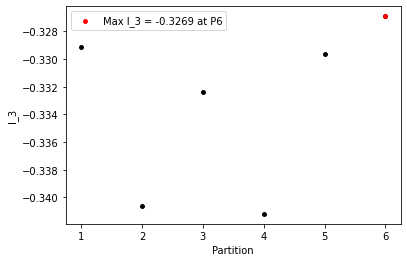


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0021  0.01    0.0086]
 [ 0.0024  0.0111  0.0098]
 [ 0.0003  0.     -0.0001]
 [-0.0002  0.0004 -0.0004]]

Matrix B:
[[ 1.1126  0.9191  0.1101 -0.1201]
 [ 5.3702  4.1958  0.0147  0.2274]
 [ 4.6088  3.6921 -0.0439 -0.2324]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9954 -0.0213 -0.0186]
 [-0.0213  0.8996 -0.087 ]
 [-0.0186 -0.087   0.9243]]

Minimum value of the cost function:
-6.7485

Mutual information of the encoder:
0.0996

Mutual information of the decoder:
0.0996

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.      0.      0.0025  0.    ]
 [ 0.   

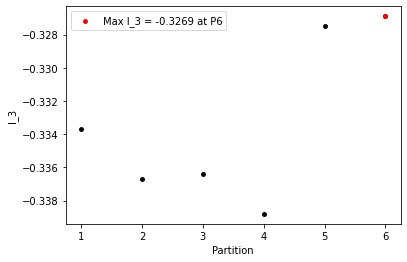


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0052 -0.0024  0.0112]
 [ 0.0066 -0.003   0.0142]
 [ 0.      0.0003  0.    ]
 [ 0.0019 -0.0001 -0.0009]]

Matrix B:
[[ 2.747   2.5053  0.0115  1.2086]
 [-1.2654 -1.1438  0.1008 -0.0467]
 [ 5.9468  5.4227  0.0161 -0.5682]]

Covariance matrix of Z:
[[0.0015 0.     0.     0.    ]
 [0.     0.0021 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.967   0.0141 -0.0652]
 [ 0.0141  0.9935  0.0304]
 [-0.0652  0.0304  0.8559]]

Minimum value of the cost function:
-6.7484

Mutual information of the encoder:
0.1011

Mutual information of the decoder:
0.1011

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0.      0.      0.0025  0.    ]
 [ 0.  

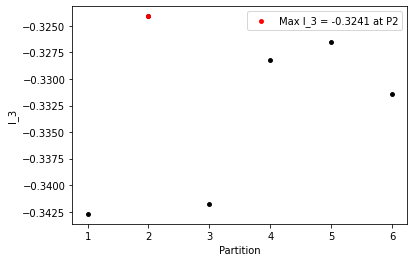


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0076  0.0003  0.0093]
 [ 0.0105  0.0003  0.0129]
 [ 0.0001  0.0003 -0.0001]
 [ 0.0012 -0.0005 -0.001 ]]

Matrix B:
[[ 3.9827  4.0457  0.0277  0.7489]
 [ 0.1392  0.1337  0.1175 -0.2987]
 [ 4.8954  4.9764 -0.0257 -0.6008]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0021 0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9264 -0.0021 -0.0887]
 [-0.0021  0.9997 -0.0033]
 [-0.0887 -0.0033  0.8895]]

Minimum value of the cost function:
-6.7483

Mutual information of the encoder:
0.1017

Mutual information of the decoder:
0.1017

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024 -0.      0.    ]
 [ 0.     -0.      0.0025  0.    ]
 [-0

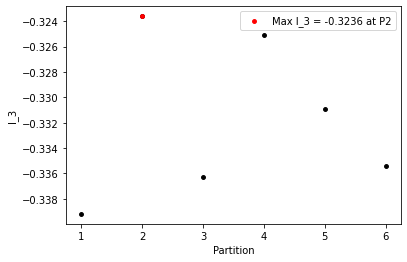


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0365  0.0015 -0.0189]
 [ 0.0266  0.002   0.0409]
 [-0.     -0.     -0.    ]
 [ 0.002  -0.0398  0.0006]]

Matrix B:
[[ 20.4628   9.4321  -0.       1.234 ]
 [  0.7963   0.7562  -0.     -25.0287]
 [-13.329   18.258   -0.       0.3992]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-16557.3394

Mutual information of the encoder:
67.8445

Mutual information of the decoder:
67.8221

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.      0.0025  0

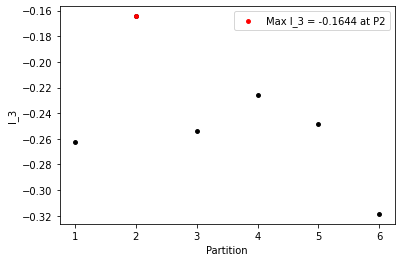


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.005 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.016   0.0372 -0.0071]
 [ 0.0238  0.0225  0.0363]
 [ 0.0376  0.0103 -0.0311]
 [-0.     -0.     -0.    ]]

Matrix B:
[[-10.7572  10.8502  15.1316   0.    ]
 [ 21.0947   7.6599   4.1502  -0.    ]
 [ -6.0266  15.7    -12.4822  -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-9.514

Mutual information of the encoder:
69.3147

Mutual information of the decoder:
69.2923

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.      0.0025  0.    ]

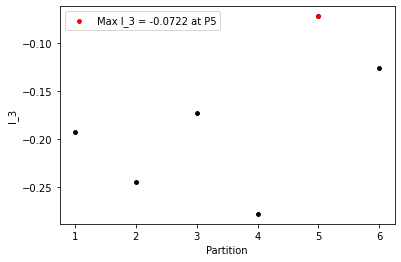


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0256 -0.0312  0.008 ]
 [ 0.0324  0.0266  0.0252]
 [ 0.     -0.     -0.    ]
 [-0.0199 -0.0077  0.0337]]

Matrix B:
[[ 13.6612  12.423    0.     -12.486 ]
 [-19.9542  12.7929  -0.      -4.8365]
 [  3.496   10.2422  -0.      21.1855]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
132373.2047

Mutual information of the encoder:
69.4386

Mutual information of the decoder:
69.4163

Value of Sigma_X:
[[ 1.005  0.    -0.   ]
 [ 0.     1.005  0.   ]
 [-0.     0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [ 0.     -0.      0.0025 -0. 

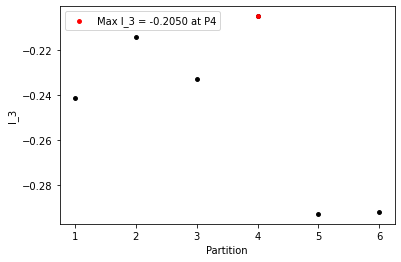


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0319 -0.0256  0.0039]
 [ 0.0159  0.0184  0.0424]
 [-0.     -0.     -0.    ]
 [-0.0231 -0.0258  0.0199]]

Matrix B:
[[ 18.2702   5.1314  -0.     -14.5093]
 [-16.2229   9.0706  -0.     -16.1821]
 [  0.2057  17.728   -0.      12.4794]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
33086.1757

Mutual information of the encoder:
68.3424

Mutual information of the decoder:
68.32

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005  0.   ]
 [-0.     0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.      0.    ]
 [ 0.0002  0.0024 -0.      0.    ]
 [-0.     -0.      0.0025  0.   

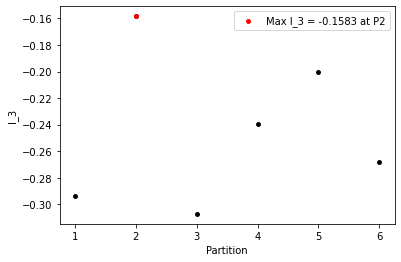


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0131  0.0115  0.0373]
 [ 0.0471 -0.01   -0.0082]
 [ 0.      0.      0.    ]
 [ 0.0055  0.0372 -0.0134]]

Matrix B:
[[ 5.4749 19.2843  0.      3.4706]
 [ 7.3579 -4.7809  0.     23.3474]
 [22.6475 -5.3055  0.     -8.4243]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
33086.1708

Mutual information of the encoder:
68.8344

Mutual information of the decoder:
68.812

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.      0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [ 0.      0.      0.0025  0.    ]
 [ 0.   

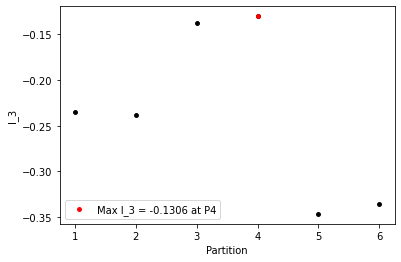


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0099 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0167  0.0271  0.0259]
 [-0.0177 -0.0205  0.0405]
 [ 0.0407 -0.0284  0.0034]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 10.9238  -8.3619  16.4416  -0.    ]
 [ 17.2668 -10.0674 -11.4786   0.    ]
 [ 13.5092  15.9281   1.3764  -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
5.9189008128332245e+25

Mutual information of the encoder:
141.6833

Mutual information of the decoder:
141.6387

Value of Sigma_X:
[[ 1.01    0.     -0.    ]
 [ 0.      1.01   -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [-0. 

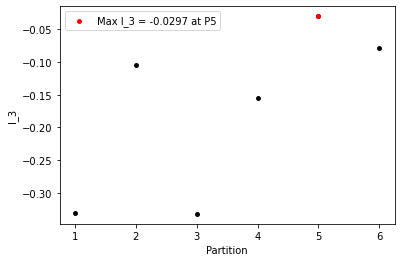


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0099 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0365 -0.0091  0.0163]
 [ 0.0011  0.0379  0.0306]
 [-0.0224 -0.0275  0.0349]
 [-0.      0.      0.    ]]

Matrix B:
[[ 21.8635  -1.3493  -9.05    -0.    ]
 [ -7.3294  16.5564 -11.1228  -0.    ]
 [  8.2606  12.2084  14.084    0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-7.8918677504443e+25

Mutual information of the encoder:
142.2384

Mutual information of the decoder:
142.1938

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.01   -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024 -0.      0.    ]
 [ 0.   

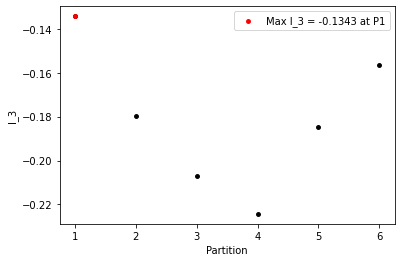


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0097 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0033  0.039  -0.0124]
 [ 0.0102  0.0183  0.044 ]
 [-0.     -0.     -0.    ]
 [ 0.0388 -0.0055 -0.0067]]

Matrix B:
[[ 1.4785  4.1658 -0.     24.5219]
 [22.4575  5.8209 -0.     -3.4427]
 [-9.6667 19.3324  0.     -4.2475]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-7.8918677504443e+25

Mutual information of the encoder:
142.9661

Mutual information of the decoder:
142.9216

Value of Sigma_X:
[[ 1.01   -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002 -0.     -0.    ]
 [ 0.0002  0.0024 -0.     -0.    ]
 [-0.     -0.      0.0

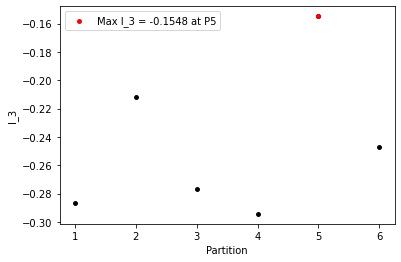


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0099 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0037 -0.0008  0.0014]
 [ 0.0446 -0.0094  0.0173]
 [-0.0197 -0.0121  0.044 ]
 [ 0.0033  0.0378  0.0119]]

Matrix B:
[[ 0.     18.7595 -7.9567  2.1031]
 [-0.     -3.9511 -4.9034 23.8796]
 [ 0.      7.2995 17.7941  7.5207]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
-1.57837355008886e+26

Mutual information of the encoder:
143.6558

Mutual information of the decoder:
143.6113

Value of Sigma_X:
[[ 1.0099  0.     -0.    ]
 [ 0.      1.01    0.    ]
 [-0.      0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024  0.     -0.    ]
 [ 0.      0.      0

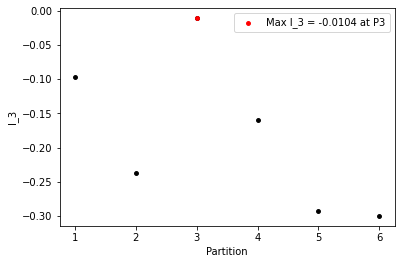


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0097 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0046  0.0253  0.032 ]
 [-0.0033 -0.0347  0.0341]
 [ 0.     -0.      0.    ]
 [ 0.0394 -0.0053 -0.0015]]

Matrix B:
[[  2.9179  -1.6514   0.      24.8855]
 [ 16.9056 -16.0029  -0.      -3.3243]
 [ 17.483   12.8902   0.      -0.9389]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.7368

Mutual information of the encoder:
142.1888

Mutual information of the decoder:
142.1443

Value of Sigma_X:
[[ 1.01    0.     -0.    ]
 [ 0.      1.01   -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.     -0.    ]
 [ 0.0002  0.0024  0.      0.    ]
 [ 0.      0.      0.

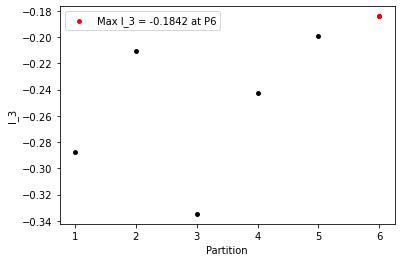

Scenario 3:
Given sigma_v1 = 0.01, (alpha, beta) = (2, 4), and (sigma_z2, sigma_z3) = (0.02, 0.03):

Covariance matrix of generative variable V:
[[0.0001 0.0002 0.0004]
 [0.0002 0.0008 0.0008]
 [0.0004 0.0008 0.0025]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0017 0.0002 0.0004 0.    ]
 [0.0002 0.0024 0.0008 0.    ]
 [0.0004 0.0008 0.0041 0.    ]
 [0.     0.     0.     0.0016]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0088  0.0045  0.0029]
 [ 0.0182  0.0094  0.0059]
 [ 0.0302  0.0156  0.0098]
 [-0.      0.      0.    ]]

Matrix B:
[[ 3.144   5.319   6.0262 -0.    ]
 [ 1.6201  2.7408  3.1053  0.    ]
 [ 1.0177  1.7217  1.9507  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0

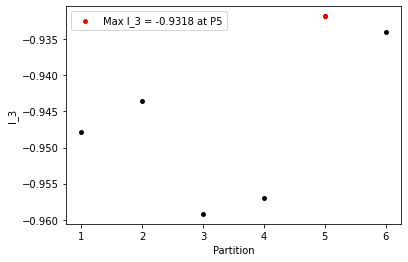


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0055  0.0075 -0.0045]
 [ 0.0114  0.0155 -0.0093]
 [ 0.0189  0.0257 -0.0154]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 1.9643  3.3228  3.7672  0.    ]
 [ 2.669   4.5148  5.1186 -0.    ]
 [-1.5995 -2.7057 -3.0676  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8802 -0.1628  0.0976]
 [-0.1628  0.7788  0.1325]
 [ 0.0976  0.1325  0.9206]]

Minimum value of the cost function:
-6.4068

Mutual information of the encoder:
0.2727

Mutual information of the decoder:
0.277

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 0

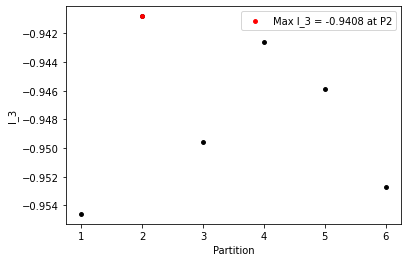


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0082  0.0033  0.0053]
 [ 0.017   0.0067  0.011 ]
 [ 0.0282  0.0112  0.0183]
 [-0.      0.      0.    ]]

Matrix B:
[[ 2.9301  4.956   5.6227 -0.    ]
 [ 1.1609  1.9636  2.2278  0.    ]
 [ 1.8978  3.2099  3.6418  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7333 -0.1057 -0.1728]
 [-0.1057  0.9581 -0.0685]
 [-0.1728 -0.0685  0.8881]]

Minimum value of the cost function:
-6.4067

Mutual information of the encoder:
0.2728

Mutual information of the decoder:
0.2771

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]
 [-0.

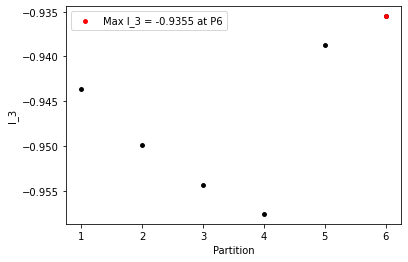


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0065  0.0021  0.0077]
 [ 0.0135  0.0044  0.0159]
 [ 0.0224  0.0073  0.0264]
 [-0.      0.      0.    ]]

Matrix B:
[[ 2.3272  3.9358  4.4684 -0.    ]
 [ 0.7635  1.2912  1.466   0.    ]
 [ 2.7442  4.6411  5.2692  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.8316 -0.0552 -0.1985]
 [-0.0552  0.9819 -0.0651]
 [-0.1985 -0.0651  0.7659]]

Minimum value of the cost function:
-6.4067

Mutual information of the encoder:
0.2729

Mutual information of the decoder:
0.2772

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]
 [-0.      0.

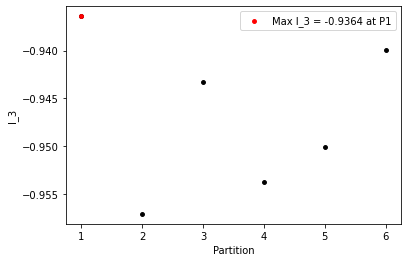


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0008  0.0065  0.008 ]
 [ 0.0017  0.0134  0.0165]
 [ 0.0028  0.0223  0.0274]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 0.2876  0.4864  0.5526 -0.    ]
 [ 2.3161  3.9166  4.4497  0.    ]
 [ 2.8421  4.8061  5.4602 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.0019 0.     0.    ]
 [0.     0.     0.0028 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9974 -0.0207 -0.0254]
 [-0.0207  0.8331 -0.2048]
 [-0.0254 -0.2048  0.7487]]

Minimum value of the cost function:
-6.4066

Mutual information of the encoder:
0.273

Mutual information of the decoder:
0.2772

Value of Sigma_X:
[[ 1.  0.  0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]
 [-0. 

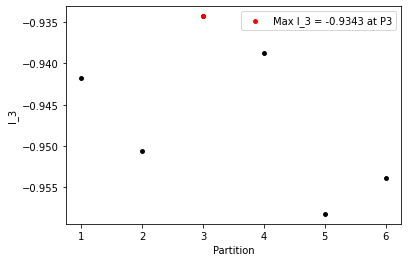


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0088 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0092  0.0035  0.0029]
 [ 0.0188  0.0071  0.0059]
 [ 0.0332  0.0126  0.0104]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 3.2054  5.3337  6.742  -0.    ]
 [ 1.2166  2.024   2.5586  0.    ]
 [ 1.0058  1.6742  2.116  -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.6462 -0.1343 -0.111 ]
 [-0.1343  0.9491 -0.0421]
 [-0.111  -0.0421  0.9652]]

Minimum value of the cost function:
-6.4751

Mutual information of the encoder:
0.2895

Mutual information of the decoder:
0.2918

Value of Sigma_X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 0.     -0

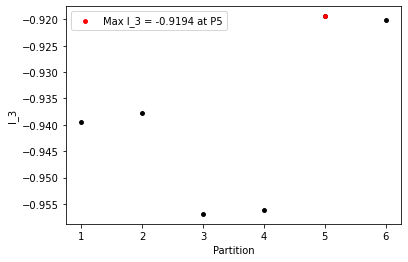


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0087 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0086  0.0052  0.002 ]
 [ 0.0176  0.0107  0.0041]
 [ 0.031   0.0189  0.0072]
 [-0.      0.     -0.    ]]

Matrix B:
[[ 2.9936  4.9806  6.302  -0.    ]
 [ 1.8203  3.0283  3.8318  0.    ]
 [ 0.6948  1.1557  1.4624 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.6911 -0.1878 -0.0717]
 [-0.1878  0.8858 -0.0436]
 [-0.0717 -0.0436  0.9834]]

Minimum value of the cost function:
-6.4751

Mutual information of the encoder:
0.2896

Mutual information of the decoder:
0.2919

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 

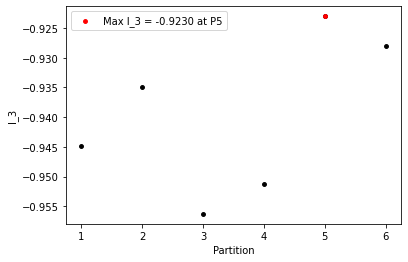


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0087 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0078  0.0014  0.0066]
 [ 0.0159  0.0028  0.0134]
 [ 0.0281  0.0049  0.0236]
 [ 0.      0.     -0.    ]]

Matrix B:
[[ 2.7088  4.5055  5.7069  0.    ]
 [ 0.4705  0.7824  0.9911  0.    ]
 [ 2.2783  3.7901  4.8004 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7469 -0.044  -0.2129]
 [-0.044   0.9924 -0.037 ]
 [-0.2129 -0.037   0.8209]]

Minimum value of the cost function:
-6.475

Mutual information of the encoder:
0.2898

Mutual information of the decoder:
0.292

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 0.  

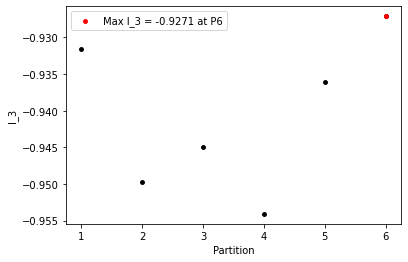


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0087 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0018  0.0064  0.0078]
 [ 0.0037  0.0132  0.0159]
 [ 0.0066  0.0232  0.0281]
 [ 0.     -0.      0.    ]]

Matrix B:
[[ 0.6339  1.0539  1.3364  0.    ]
 [ 2.2404  3.726   4.7242 -0.    ]
 [ 2.7056  4.4997  5.7052  0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9861 -0.049  -0.0592]
 [-0.049   0.8267 -0.2093]
 [-0.0592 -0.2093  0.7472]]

Minimum value of the cost function:
-6.4749

Mutual information of the encoder:
0.2899

Mutual information of the decoder:
0.2921

Value of Sigma_X:
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 0

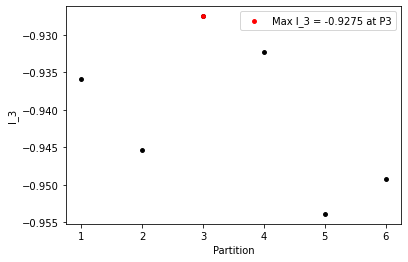


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0086 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0015  0.0009  0.0101]
 [-0.003   0.0019  0.0207]
 [-0.0054  0.0033  0.0365]
 [-0.      0.     -0.    ]]

Matrix B:
[[-0.5183 -0.8619 -1.0939 -0.    ]
 [ 0.319   0.5291  0.6721  0.    ]
 [ 3.5161  5.8466  7.4205 -0.    ]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0027 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.9907  0.0057  0.063 ]
 [ 0.0057  0.9965 -0.0387]
 [ 0.063  -0.0387  0.5727]]

Minimum value of the cost function:
-6.4748

Mutual information of the encoder:
0.29

Mutual information of the decoder:
0.2922

Value of Sigma_X:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 0.

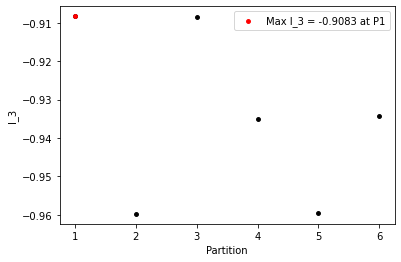


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0063 -0.0033  0.0078]
 [ 0.0158 -0.0099  0.0088]
 [ 0.0282 -0.0167  0.0215]
 [-0.     -0.      0.    ]]

Matrix B:
[[ 1.8080e+00  4.5066e+00  5.8263e+00 -1.3900e-02]
 [-7.8880e-01 -2.8980e+00 -3.4237e+00 -1.9800e-02]
 [ 3.2704e+00  1.8556e+00  4.5691e+00  2.9000e-03]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0026 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7528  0.1475 -0.1789]
 [ 0.1475  0.9118  0.1052]
 [-0.1789  0.1052  0.86  ]]

Minimum value of the cost function:
-6.5436

Mutual information of the encoder:
0.3188

Mutual information of the decoder:
0.3188

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008

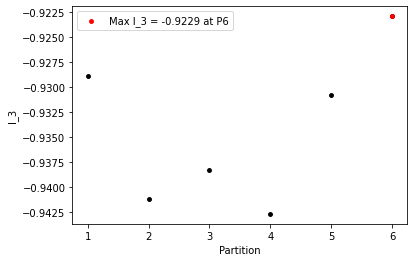


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0071 -0.002   0.0068]
 [ 0.0139 -0.0028  0.0142]
 [ 0.0279 -0.0065  0.0278]
 [ 0.     -0.0001 -0.    ]]

Matrix B:
[[ 2.3653  3.625   5.8664  0.0113]
 [-0.7934 -0.6421 -1.3919 -0.0413]
 [ 2.1687  3.7797  5.8404 -0.0208]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7693  0.0534 -0.2307]
 [ 0.0534  0.9875  0.0532]
 [-0.2307  0.0532  0.7691]]

Minimum value of the cost function:
-6.5435

Mutual information of the encoder:
0.3212

Mutual information of the decoder:
0.3212

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004  0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041  0.    ]
 [ 

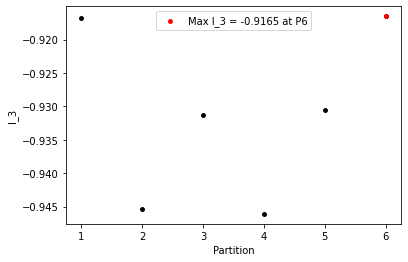


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0084  0.0023  0.0052]
 [ 0.0187  0.0031  0.007 ]
 [ 0.0355  0.0072  0.0164]
 [ 0.     -0.0001  0.0001]]

Matrix B:
[[ 2.5973e+00  5.0916e+00  7.4231e+00  5.0000e-04]
 [ 9.0100e-01  6.8830e-01  1.5272e+00 -7.9200e-02]
 [ 2.0420e+00  1.5671e+00  3.4932e+00  3.3500e-02]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.6192 -0.0747 -0.1706]
 [-0.0747  0.9849 -0.0345]
 [-0.1706 -0.0345  0.9212]]

Minimum value of the cost function:
-6.5434

Mutual information of the encoder:
0.3209

Mutual information of the decoder:
0.3209

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0. 

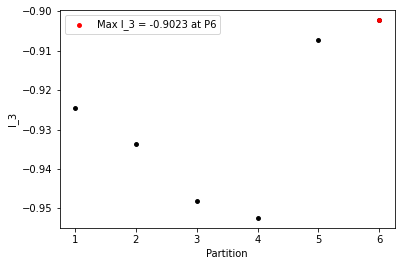


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0086  0.0049  0.0013]
 [ 0.0167  0.0108  0.0019]
 [ 0.0336  0.0213  0.0042]
 [ 0.0001 -0.0001 -0.0005]]

Matrix B:
[[ 2.8972  4.3612  7.0662  0.0755]
 [ 1.4976  2.8939  4.4811 -0.06  ]
 [ 0.5108  0.4742  0.8823 -0.3008]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.6646 -0.2119 -0.0419]
 [-0.2119  0.8659 -0.0265]
 [-0.0419 -0.0265  0.9946]]

Minimum value of the cost function:
-6.5434

Mutual information of the encoder:
0.3219

Mutual information of the decoder:
0.3219

Value of Sigma_X:
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]
 [-0

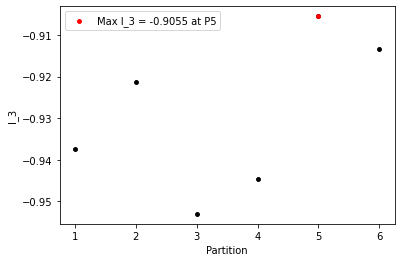


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0069 -0.0005  0.0072]
 [ 0.0151 -0.0016  0.0131]
 [ 0.029  -0.0025  0.0274]
 [ 0.      0.0001 -0.    ]]

Matrix B:
[[ 2.1801  4.0717  6.0724  0.0187]
 [-0.0927 -0.4842 -0.5002  0.0503]
 [ 2.4797  3.3145  5.8003 -0.0153]]

Covariance matrix of Z:
[[0.0016 0.     0.     0.    ]
 [0.     0.002  0.     0.    ]
 [0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of W:
[[ 0.7472  0.0225 -0.2355]
 [ 0.0225  0.998   0.0207]
 [-0.2355  0.0207  0.7797]]

Minimum value of the cost function:
-6.5433

Mutual information of the encoder:
0.3221

Mutual information of the decoder:
0.322

Value of Sigma_X:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]
 [-0.

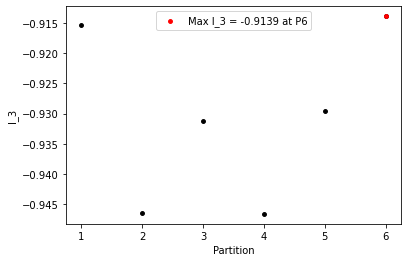


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0082  0.0364  0.0172]
 [ 0.0063  0.0017  0.0111]
 [ 0.0366 -0.0054  0.0521]
 [-0.0306 -0.0163  0.0198]]

Matrix B:
[[ -7.1395  -0.       9.6616 -19.2159]
 [ 22.3671   0.      -3.5071 -10.211 ]
 [  7.3347   0.      12.0512  12.4339]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-9.3033

Mutual information of the encoder:
68.9475

Mutual information of the decoder:
68.9252

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041 -0.   

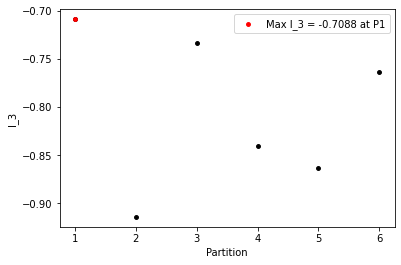


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0016  0.0065  0.0006]
 [ 0.0025  0.0333 -0.0357]
 [ 0.0166  0.0542  0.0295]
 [ 0.0385 -0.0088 -0.0055]]

Matrix B:
[[  0.      -0.3435   4.1265  24.2017]
 [  0.      10.1867  11.2973  -5.5074]
 [ -0.     -18.5469  10.8404  -3.4731]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-9.3113

Mutual information of the encoder:
69.7457

Mutual information of the decoder:
69.7233

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.0004 0.    ]
 [0.0002 0.0024 0.0008 0.    ]
 [0.0004 0.0008 0.0041 0.    ]
 [0.     

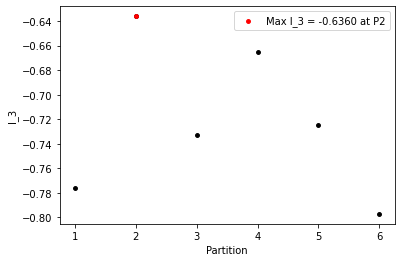


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0315 -0.0251  0.0082]
 [ 0.011   0.0064  0.0017]
 [ 0.0461  0.0438  0.006 ]
 [-0.0078  0.0029  0.039 ]]

Matrix B:
[[ 16.3453   0.       9.6946  -4.9171]
 [-17.8007   0.      12.4833   1.7985]
 [  4.5854   0.       1.0289  24.5093]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0.  0.]
 [-0.  0.  0.]]

Minimum value of the cost function:
-9.3161

Mutual information of the encoder:
70.2334

Mutual information of the decoder:
70.211

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0041 -0.    ]


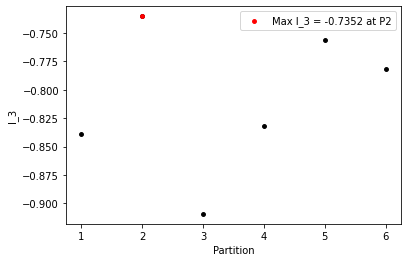


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0284  0.0183 -0.0235]
 [-0.0028  0.0118  0.0041]
 [-0.0039  0.0557  0.0311]
 [ 0.0288  0.015  -0.0232]]

Matrix B:
[[-16.9615  -0.       0.7086  18.0877]
 [  7.7731   0.      12.8867   9.3961]
 [-16.0294  -0.       9.1819 -14.5831]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
132373.4144

Mutual information of the encoder:
69.187

Mutual information of the decoder:
69.1646

Value of Sigma_X:
[[ 1.005  0.     0.   ]
 [ 0.     1.005 -0.   ]
 [ 0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[0.0017 0.0002 0.0004 0.    ]
 [0.0002 0.0024 0.0008 0.    ]
 [0.0004 0.0008 0.0041 0.    ]
 [0.   

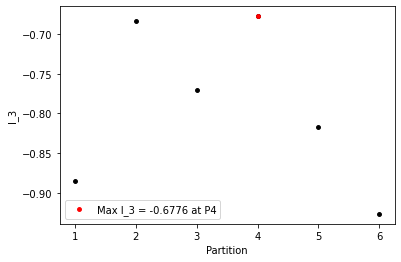


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0295  0.0287  0.0007]
 [ 0.0021  0.0089  0.009 ]
 [ 0.0228  0.0362  0.0474]
 [-0.0205 -0.0217  0.0264]]

Matrix B:
[[-19.1855  -0.       7.4703 -12.8719]
 [ 15.2121   0.       7.38   -13.6582]
 [ -2.3591  -0.      11.8578  16.6097]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-264774.7446

Mutual information of the encoder:
69.0806

Mutual information of the decoder:
69.0582

Value of Sigma_X:
[[ 1.005 -0.    -0.   ]
 [-0.     1.005 -0.   ]
 [-0.    -0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0041  0

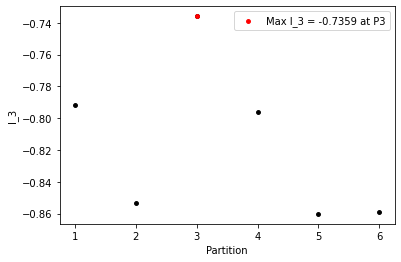


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0098 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0036  0.0044  0.0036]
 [ 0.0401  0.0237 -0.0142]
 [ 0.0163  0.0359  0.0501]
 [ 0.0225 -0.0297  0.014 ]]

Matrix B:
[[  0.      16.6405   0.7566  14.2057]
 [  0.       7.5249   7.3736 -18.7475]
 [ -0.     -10.7962  14.4402   8.8287]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0.  0. -0.]
 [ 0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-6.31349420035544e+26

Mutual information of the encoder:
145.0052

Mutual information of the decoder:
144.9606

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.00

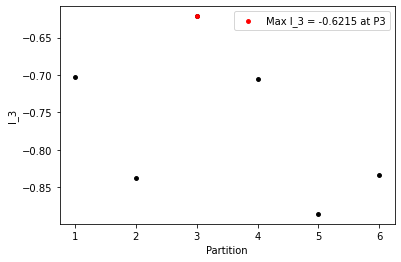


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0019 -0.011   0.0395]
 [ 0.0097  0.0048  0.0068]
 [ 0.0524  0.0297  0.0208]
 [-0.0216  0.0325  0.008 ]]

Matrix B:
[[ -4.2488  -0.      13.3189 -13.6292]
 [ -8.4724  -0.       8.1397  20.4854]
 [ 22.7643   0.       2.9094   5.0804]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.5089

Mutual information of the encoder:
141.2475

Mutual information of the decoder:
141.203

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.

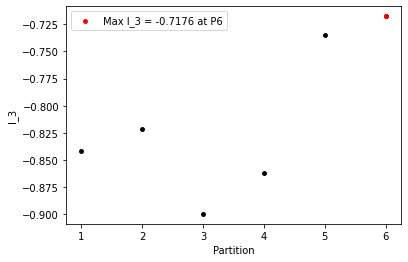


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0403  0.0029 -0.0068]
 [ 0.0056  0.0087  0.0076]
 [ 0.0139  0.0451  0.0428]
 [-0.0067  0.0281 -0.0274]]

Matrix B:
[[ 23.7125   0.       1.0983  -4.2049]
 [ -0.9147  -0.      11.1931  17.7314]
 [ -6.7028  -0.      11.2081 -17.2956]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0. -0.]
 [-0.  0. -0.]
 [-0. -0.  0.]]

Minimum value of the cost function:
-11.5507

Mutual information of the encoder:
143.3375

Mutual information of the decoder:
143.2929

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008  0.    ]
 [ 0.0004  0.0008  0.0

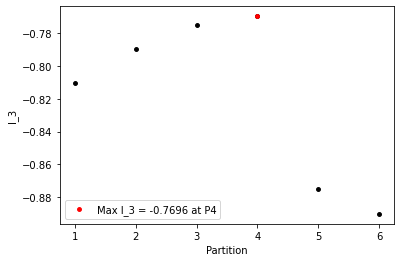


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0098 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0065 -0.0017 -0.0002]
 [ 0.0185 -0.0451 -0.0009]
 [ 0.0631  0.0084 -0.0013]
 [ 0.0009 -0.0005  0.0398]]

Matrix B:
[[  0.       2.7888  15.0108   0.5379]
 [ -0.     -21.0289   6.1706  -0.298 ]
 [ -0.      -0.3092  -0.2482  25.1165]]

Covariance matrix of Z:
[[0.0017 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0.  0.]
 [ 0.  0.  0.]]

Minimum value of the cost function:
-11.5604

Mutual information of the encoder:
143.824

Mutual information of the decoder:
143.7794

Value of Sigma_X:
[[ 1.0099  0.      0.    ]
 [ 0.      1.01   -0.    ]
 [ 0.     -0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004  0.0008  0.0

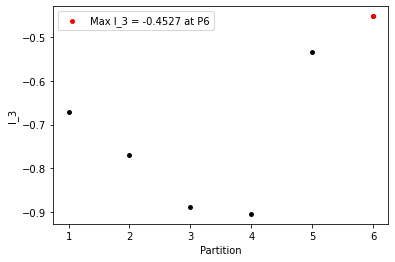


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0305  0.0043 -0.0271]
 [ 0.0112  0.0026  0.0057]
 [ 0.0475  0.012   0.0407]
 [ 0.0077 -0.039   0.0025]]

Matrix B:
[[ 15.725    0.      10.1635   4.8857]
 [  1.933    0.       2.7675 -24.5957]
 [-18.8953   0.      11.881    1.5498]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0022 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]

Minimum value of the cost function:
6.31349420035544e+26

Mutual information of the encoder:
144.0293

Mutual information of the decoder:
143.9848

Value of Sigma_X:
[[ 1.0099 -0.     -0.    ]
 [-0.      1.0099 -0.    ]
 [-0.     -0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0017  0.0002  0.0004 -0.    ]
 [ 0.0002  0.0024  0.0008 -0.    ]
 [ 0.0004

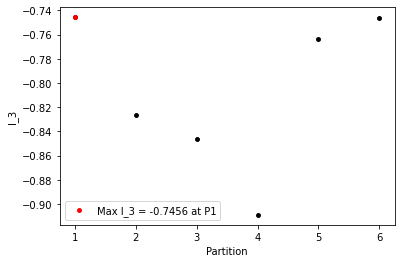

In [11]:
for case in range(num_cases):
    # Compute Sigma_Y given Sigma_V
    Sigma_V = generate_Sigma_V(case)
    
    Sigma_Y = eigenvectors @ Sigma_V @ eigenvectors.T + Sigma_Z_tilde
    print(colored('\nCovariance matrix of input data Y:', 'blue', attrs=['bold']))
    print(np.round(Sigma_Y, 4))
    is_positive_definite(Sigma_Y)
    
    # Constants
    MAX_SOLS = 5
    is_array = 1
    flag = 0
    case_num = 1

    # Initiate arrays
    min_recon_err_arr = []
    min_en_mi_arr = []
    min_de_mi_arr = []
    all_recon_mi_arr = []
    satisfied_recon_mi_arr = []
    satisfied_gamma_lambda_arr = []
    
    # Iteration step
    for i in range(0, len(gamma_arr)):
        gamma = gamma_arr[i]
        for j in range(0, len(lambda_arr)):
            lamda = lambda_arr[j]
        
            min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
            first_iter = 1
            for num_sols in range(0, MAX_SOLS):
                current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
                # Check for unique optimal solutions for each (gamma, lambda) pair
                if first_iter == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                        is_unique = 1
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
                    first_iter = 0
                else:
                    if is_unique == 1:
                        if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                            unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                        else:
                            is_unique = 0
    
                # Return the solution with smallest reconstruction error
                if current_recon_err < min_recon_err:
                    min_recon_err = current_recon_err
                    min_en_mi = current_en_mi
                    min_de_mi = current_de_mi
                    min_opt_sol = current_opt_sol
                
            min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
            min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
            min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
            all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
            case_num += 1
        
            if min_recon_err > MAX_RECON_ERR:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            else:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
                satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
                satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            if is_unique == 1:
                print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
            else:
                print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
            print_optimal_solution(min_opt_sol, m)
        
            # Compute mutual information I(V;X) and I_3
            B_opt = min_opt_sol[n*m:2*n*m].reshape((m, n))
            Sigma_W_opt = min_opt_sol[2*n*m+n*n:2*n*m+n*n+m*m].reshape((m, m))
        
            mutual_info_VX = mi_VX(B_opt, Sigma_W_opt)
            print('\nMutual information between generative variable and latent variable:')
            print(round(mutual_info_VX, 4))
        
            cov_XV = covariance_matrix_XV(B_opt)
            I3_arr = max_I3(cov_XV)
            plot_I3_vs_partition(I3_arr)